## Making Figure 2

Start by importing modules, data and defining functions.

In [11]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt
import numpyro.distributions as dist
import h5py

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80
tmp_max = 100.
tmp_min = 2.

In [12]:
data_peak_analysis = h5py.File("../data/peak_analysis.hdf", "r")

m_grid = np.linspace(2,120,500)

In [9]:
def massModel_variation_all_m1(m1, alpha_ref, mu_m1, high_mu, width_mu, middle_mu, 
                               sig_m1, high_sig, width_sig, middle_sig, 
                               log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, mMax, mMin, dmMax, dmMin, zs):
    
    p_m1_pl = (1.+alpha_ref)*m1**(alpha_ref)/(tmp_max**(1.+alpha_ref) - tmp_min**(1.+alpha_ref))

    new_mu_m1 = sigmoid_no_delta(mu_m1, high_mu, width_mu, middle_mu, zs)
    new_sig_m1 = sigmoid_no_delta(sig_m1, high_sig, width_sig, middle_sig, zs)

    p_m1_peak = jnp.exp(-(m1-new_mu_m1)**2/(2.*new_sig_m1**2))/jnp.sqrt(2.*np.pi*new_sig_m1**2)

    # Compute low- and high-mass filters
    low_filter = jnp.exp(-(m1-mMin)**2/(2.*dmMin**2))
    low_filter = jnp.where(m1<mMin,low_filter,1.)
    high_filter = jnp.exp(-(m1-mMax)**2/(2.*dmMax**2))
    high_filter = jnp.where(m1>mMax,high_filter,1.)

    new_f_peak = sigmoid_no_delta(log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, zs) 
    actual_f_peak = 10.**(new_f_peak)
    combined_p = jnp.array((actual_f_peak*p_m1_peak + (1. - actual_f_peak)*p_m1_pl)*low_filter*high_filter)
    return combined_p

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

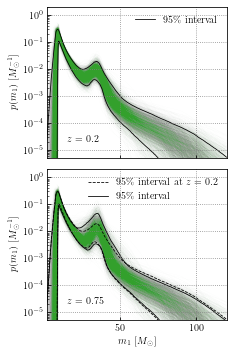

In [13]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.5*cm, 2*6.375*cm))
z = 0.75

ax1.set_rasterization_zorder(2)

pm_matrix = np.zeros((len(data_peak_analysis['posterior/alpha_ref']), len(m_grid)))

for i in range(len(data_peak_analysis['posterior/alpha_ref'])):
    p_m = massModel_variation_all_m1(m_grid,data_peak_analysis['posterior/alpha_ref'][:][i],
                                     data_peak_analysis['posterior/mu_m1'][:][i], data_peak_analysis['posterior/high_mu'][:][i],
                                     data_peak_analysis['posterior/width_mu'][:][i], data_peak_analysis['posterior/middle_z_mu'][:][i],
                                     data_peak_analysis['posterior/sig_m1'][:][i],data_peak_analysis['posterior/high_sig'][:][i],
                                     data_peak_analysis['posterior/width_sig'][:][i], data_peak_analysis['posterior/middle_z_sig'][:][i],
                                     data_peak_analysis['posterior/log_f_peak'][:][i],data_peak_analysis['posterior/log_high_f_peak'][:][i],
                                     data_peak_analysis['posterior/width_f_peak'][:][i], data_peak_analysis['posterior/middle_z_f_peak'][:][i],
                                     data_peak_analysis['posterior/mMax'][:][i], data_peak_analysis['posterior/mMin'][:][i],
                        10.**data_peak_analysis['posterior/log_dmMax'][:][i],10.**data_peak_analysis['posterior/log_dmMin'][:][i], 0.2)
    p_m /= np.trapz(p_m,m_grid)
    pm_matrix[i, :] = p_m
    ax1.plot(m_grid,p_m,color='#33a02c',lw=0.05,alpha=0.1, zorder = 1)
    
ax1.set_yscale('log')
ax1.set_ylim(5e-6,2)
ax1.set_ylabel(r"$p(m_1)$ $[M_\odot^{-1}]$", fontsize = 10)
ax1.text(15,2e-5,f"$z$ = 0.2")
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(m_grid,np.quantile(pm_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, label=r"95$\%$ interval")
ax1.plot(m_grid,np.quantile(pm_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)

ax2.set_rasterization_zorder(2)

pm_matrix_axes_2 = np.zeros((len(data_peak_analysis['posterior/alpha_ref']), len(m_grid)))

for i in range(len(data_peak_analysis['posterior/alpha_ref'])):
    p_m = massModel_variation_all_m1(m_grid,data_peak_analysis['posterior/alpha_ref'][:][i],
                                     data_peak_analysis['posterior/mu_m1'][:][i], data_peak_analysis['posterior/high_mu'][:][i],
                                     data_peak_analysis['posterior/width_mu'][:][i], data_peak_analysis['posterior/middle_z_mu'][:][i],
                                     data_peak_analysis['posterior/sig_m1'][:][i],data_peak_analysis['posterior/high_sig'][:][i],
                                     data_peak_analysis['posterior/width_sig'][:][i], data_peak_analysis['posterior/middle_z_sig'][:][i],
                                     data_peak_analysis['posterior/log_f_peak'][:][i],data_peak_analysis['posterior/log_high_f_peak'][:][i],
                                     data_peak_analysis['posterior/width_f_peak'][:][i], data_peak_analysis['posterior/middle_z_f_peak'][:][i],
                                     data_peak_analysis['posterior/mMax'][:][i], data_peak_analysis['posterior/mMin'][:][i],
                        10.**data_peak_analysis['posterior/log_dmMax'][:][i],10.**data_peak_analysis['posterior/log_dmMin'][:][i], z)
    p_m /= np.trapz(p_m,m_grid)
    pm_matrix_axes_2[i,:] = p_m
    ax2.plot(m_grid,p_m,color='#33a02c',lw=0.05,alpha=0.1, zorder = 1)
    
ax2.set_yscale('log')
ax2.set_xlim(2,120)
ax2.set_ylim(5e-6,2)
ax2.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax2.set_ylabel(r"$p(m_1)$ $[M_\odot^{-1}]$", fontsize = 10)
ax2.text(15,2e-5,f"$z$ = {z}")
plt.xticks(fontsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.plot(m_grid,np.quantile(pm_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, linestyle='dashed', label=r'95$\%$ interval at $z$ = 0.2')
ax2.plot(m_grid,np.quantile(pm_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, linestyle='dashed')
ax2.plot(m_grid,np.quantile(pm_matrix_axes_2,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, label=r' 95$\%$ interval')
ax2.plot(m_grid,np.quantile(pm_matrix_axes_2,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)


plt.setp(ax1.get_xticklabels(), visible=False)

ax1.legend(loc='upper right', fontsize = 10)
ax2.legend(loc='upper right', fontsize = 10)

plt.tight_layout()
plt.savefig("figure_2.pdf", dpi=500, bbox_inches="tight")
plt.show()